0. Set Up

In [1]:

!git clone --branch feature/002-rotation https://github.com/antonfrancois/Demeter_metamorphosis.git

Cloning into 'Demeter_metamorphosis'...
remote: Enumerating objects: 6067, done.
remote: Counting objects: 100% (626/626), done.
remote: Compressing objects: 100% (349/349), done.
remote: Total 6067 (delta 406), reused 457 (delta 277), pack-reused 5441 (from 1)
Receiving objects: 100% (6067/6067), 634.15 MiB | 16.00 MiB/s, done.
Resolving deltas: 100% (3974/3974), done.
Updating files: 100% (179/179), done.


In [17]:
!git stash
!git pull origin feature/002-rotation

No local changes to save
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 12 (delta 7), reused 8 (delta 5), pack-reused 0 (from 0)
Unpacking objects: 100% (12/12), 775.27 KiB | 10.92 MiB/s, done.
From https://github.com/antonfrancois/Demeter_metamorphosis
 * branch            feature/002-rotation -> FETCH_HEAD
   498ecd5..9d7d3aa  feature/002-rotation -> origin/feature/002-rotation
Updating 498ecd5..9d7d3aa
Fast-forward
 examples/execute_ixi_template.ipynb | 4901 +++++++++++++++++++++--------------
 src/demeter/metamorphosis/rotate.py |   26 +-
 2 files changed, 2954 insertions(+), 1973 deletions(-)


Install packages, (needs to be executed twice because of a bug in pip. exucute, restart the kernel and re-execute this cell)

In [1]:
import subprocess
import sys, os

cwd = subprocess.check_output("pwd", text=True).strip()
if not "Demeter" in cwd:
	%cd Demeter_metamorphosis/

!pip install pynrrd
!pip install -U ipywidgets
print("\nInstalation of demeter from pip")
!pip install -e .
# !pip install -e .
!pip install simpleitk
!pip install itk

repo_path = os.path.abspath('.')
# repo_path = "/content/Demeter_metamorphosis/"
if repo_path not in sys.path:
	sys.path.insert(0, repo_path)
print(sys.path)


/content/Demeter_metamorphosis

Instalation of demeter from pip
Obtaining file:///content/Demeter_metamorphosis
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for demeter_metamorphosis (pyproject.toml) ... done
  Created wheel for demeter_metamorphosis: filename=demeter_metamorphosis-0.2.11-0.editable-py3-none-any.whl size=4322 sha256=097134ae89eff5bf75615c7ccaa199b3b6c3594fdbbf587266c0534a498040fb
  Stored in directory: /tmp/pip-ephem-wheel-cache-pfqfd40x/wheels/b0/6a/69/c66c8a74253f8baa35c990caf2c48f3d36ded6d5a7d58f0e62
Successfully built demeter_metamorphosis
  Attempting uninstall: demeter_metamorphosis
    Found existing installation: demeter_metamorphosis 0.2.11
    Uninstalling demeter_metamorphosis-0.2.11:
      Successfully uninstalled demeter_metamorphosis-0.2.11
  Using cached simpleitk-2.5.2-cp31

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# from google.colab import output
# output.enable_custom_widget_manager()

## 0.2 After jupyter restart, run:

In [1]:
# %matplotlib widget

import sys
import os


# Remplace par le chemin relatif où se trouve le package 'demeter'
# Exemple : si ton notebook est dans le dossier root du repo, et demeter est un sous-dossier
import subprocess
cwd = subprocess.check_output("pwd", text=True).strip()
if not "Demeter" in cwd:
	%cd Demeter_metamorphosis/

# repo_path = os.path.abspath('.')
repo_path = "/content/Demeter_metamorphosis/"
if repo_path not in sys.path:
	sys.path.insert(0, repo_path)
print(sys.path)



/content/Demeter_metamorphosis
['/content/Demeter_metamorphosis/', '/content', '/env/python', '/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/usr/local/lib/python3.12/dist-packages', '/content/Demeter_metamorphosis/src', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.12/dist-packages/IPython/extensions', '/root/.ipython']


# 1. Code utile

In [2]:
import os
# import nibabel as nib
# import numpy as np
import torch
# from torch.cuda import OutOfMemoryError, device
#
import demeter.utils.torchbox as tb
# import demeter.utils.axes3dsliders_plt as a3s
import demeter.utils.rigid_exploration as rg
# ## Faire Recalage Rigid + Meta
import demeter.utils.reproducing_kernels as rk
import matplotlib.pyplot as plt
#
# # %load_ext autoreload
# # %autoreload 2
import demeter.metamorphosis as mt
import demeter.metamorphosis.rotate as mtrt


# from nibabel.processing import resample_from_to
#
#
# import subprocess
# from execute_ixi_template import *
# cwd = subprocess.check_output("pwd", text=True).strip()

import examples.execute_ixi_template as eit

/usr/local/lib/python3.12/dist-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


saves_overview.csv


## Open images

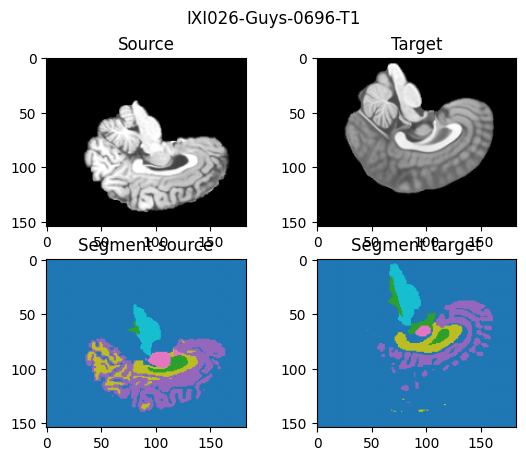

IXI026-Guys-0696-T1 image size : torch.Size([1, 1, 154, 183, 154])


In [3]:
import subprocess
cwd = subprocess.check_output("pwd", text=True).strip()
if "content" in cwd:
    template_folder = "/content/drive/MyDrive/demeter_data/ixi-T1/"
    ixi_folder = "/content/drive/MyDrive/demeter_data/ixi-T1/"
    template_seg_path = ""
    location = "colab"
    result_folder = "/content/drive/MyDrive/demeter_data/ixi_results/"
elif "gpfs" in cwd:
    template_folder = "/gpfs/workdir/francoisa/data/templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c"
    ixi_folder = "/gpfs/workdir/francoisa/data/IXI-T1_fastsurfer/"
    template_seg_path = "fastsurfer_seg/mri/"
    result_folder = "/gpfs/workdir/francoisa/data/IXI_results/"
    location = 'meso'
    # OPTIM_SAVE_DIR = "/gpfs/workdir/francoisa/saved_optim/"
else:
    template_folder ="/home/turtlefox/Documents/11_metamorphoses/data/templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c"
    ixi_folder = "/home/turtlefox/Documents/11_metamorphoses/data/IXI-T1_fastsurfer"
    template_seg_path = "fastsurfer_seg/mri/"
    result_folder = "/home/turtlefox/Documents/11_metamorphoses/data/IXI_results/"
    location = 'local'
device = "cuda:0"

pp = eit.IXIToTemplatePreprocessor(
    ixi_root=ixi_folder,
    template_root=template_folder,
    template_seg_path=template_seg_path,
    do_plot=True,
)

subjects_numbers = [26]#, 28, 26, 50,2, 12]
RECOMPUTE = False
RESIZE_FACTOR = 1 if location == 'meso' else .8

# init_csv(result_folder)

if location == "meso": # don't touch this line
    file_db = "ixi_results_tests.db"
else: # here you can sandbox what you need to do.
    # file_db = "ixi_results.db"
    file_db = "ixi_results_meso_20250917.db"
db_path = os.path.join(result_folder, file_db)

subject_name, source, target, seg_source, seg_target = pp.get_subjects_aligned(numbers=subjects_numbers, resize_factor=RESIZE_FACTOR, first_only=True)
print(subject_name, 'image size :', source.shape)

## Recherche rigide


In [4]:
# Recherche rigide
source_b, target_b, trans_s, trans_t = rg.align_barycentres(source, target, verbose=True)
id_grid = tb.make_regular_grid(source_b.shape[2:],dx_convention="2square")
seg_target_b = tb.imgDeform(seg_target, (id_grid + trans_t), mode="nearest")
seg_source_b = tb.imgDeform(seg_source, (id_grid + trans_s), mode="nearest")

S compute barycentre : tensor([-0.0286,  0.0465,  0.2288])
T compute barycentre : tensor([-0.0024, -0.0352, -0.0857])
diff :  tensor([ 0.0262, -0.0816, -0.3145])


In [7]:
kernelOperator = rk.GaussianRKHS(sigma=(15,15,15),normalized=False)
datacost = mt.Rotation_Ssd_Cost(target_b.to('cuda:0'), alpha=1)
# datacost = mt.Rotation_MutualInformation_Cost(target_b.to('cuda:0'), alpha=1)


mr = mt.rigid_along_metamorphosis(
    source_b, target_b, momenta_ini=0,
    kernelOperator= kernelOperator,
    rho = 1,
    data_term=datacost ,
    integration_steps = 10,
    cost_cst=.1,
)
top_params = rg.initial_exploration(mr,r_step=10, max_output = 15, verbose=True)
print(top_params)

[Tensor.rigid_along_metamorphosis] 
	Max Allocated: 16.56 MB | Max Reserved: 18.00 MB
Init search : 1 / 50
dict_keys(['momentum_R', 'momentum_S'])


The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4421.)


	 (tensor(128872.4688), tensor([-3.1416,  0.0000,  0.0000]))
Init search : 2 / 50
dict_keys(['momentum_R', 'momentum_S'])
	 (tensor(129139.6250), tensor([-3.1416,  0.7854,  0.0000]))
Init search : 3 / 50
dict_keys(['momentum_R', 'momentum_S'])
	 (tensor(123252.0625), tensor([-3.1416,  1.5708,  0.0000]))
Init search : 4 / 50
dict_keys(['momentum_R', 'momentum_S'])
	 (tensor(124580.7031), tensor([-3.1416,  2.3562,  0.0000]))
Init search : 5 / 50
dict_keys(['momentum_R', 'momentum_S'])
	 (tensor(132653.5156), tensor([-3.1416,  3.1416,  0.0000]))
Init search : 6 / 50
dict_keys(['momentum_R', 'momentum_S'])
	 (tensor(132659.9062), tensor([-2.4435,  0.0000,  0.0000]))
Init search : 7 / 50
dict_keys(['momentum_R', 'momentum_S'])
	 (tensor(139554.3750), tensor([-2.4435,  0.7854,  0.0000]))
Init search : 8 / 50
dict_keys(['momentum_R', 'momentum_S'])
	 (tensor(132598.6406), tensor([-2.4435,  1.5708,  0.0000]))
Init search : 9 / 50
dict_keys(['momentum_R', 'momentum_S'])
	 (tensor(128338.6172), 

In [8]:
best_loss, best_momentum_R, best_momentum_T, best_momentum_S, best_rot = rg.optimize_on_rigid(mr, top_params, n_iter=10,verbose=True)


>>>>>>>>>>
0/15 Optimize wit params [0.34906578063964844, 0.0, 0.0]
momenta type <class 'dict'>
	[DataCost  :(Rotation_Ssd_Cost) alpha = 1] :
	ssd = 110819.71875, ssd_rot = 110819.71875
	[DataCost  :(Rotation_Ssd_Cost) alpha = 1] :
	ssd = 110819.71875, ssd_rot = 110819.71875
	[DataCost  :(Rotation_Ssd_Cost) alpha = 1] :
	ssd = 147044.5625, ssd_rot = 147044.5625
	[DataCost  :(Rotation_Ssd_Cost) alpha = 1] :
	ssd = 55545.56640625, ssd_rot = 55545.56640625
	[DataCost  :(Rotation_Ssd_Cost) alpha = 1] :
	ssd = 71292.078125, ssd_rot = 71292.078125
	[DataCost  :(Rotation_Ssd_Cost) alpha = 1] :
	ssd = 50376.7734375, ssd_rot = 50376.7734375
	[DataCost  :(Rotation_Ssd_Cost) alpha = 1] :
	ssd = 48906.58984375, ssd_rot = 48906.58984375
	[DataCost  :(Rotation_Ssd_Cost) alpha = 1] :
	ssd = 45590.7734375, ssd_rot = 45590.7734375
	[DataCost  :(Rotation_Ssd_Cost) alpha = 1] :
	ssd = 41833.34375, ssd_rot = 41833.34375
	[DataCost  :(Rotation_Ssd_Cost) alpha = 1] :
	ssd = 39624.69140625, ssd_rot = 39624.6

In [6]:
best_momentum_R = torch. tensor([[-0.0014, -0.0377, -0.0019],
        [ 0.0375, -0.0083,  0.0827],
        [-0.0043, -0.0826, -0.0069]])
best_momentum_T = torch. tensor([ 0.0014, -0.0064, -0.0053])
best_momentum_S = torch. tensor([0.1278, 0.0856, 0.1622])

## Check rigid search

tensor([[-0.0014, -0.0377, -0.0019],
        [ 0.0375, -0.0083,  0.0827],
        [-0.0043, -0.0826, -0.0069]], requires_grad=True)
tensor([ 0.0014, -0.0064, -0.0053], requires_grad=True)
[Tensor.rigid_along_metamorphosis] 
	Max Allocated: 16.56 MB | Max Reserved: 18.00 MB


The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4421.)


Estimated affines values:
	 rotation matrix : tensor([[ 9.9929e-01, -3.7605e-02, -3.5476e-04],
        [ 3.7506e-02,  9.9588e-01,  8.2574e-02],
        [-2.7519e-03, -8.2529e-02,  9.9658e-01]], grad_fn=<MmBackward0>)
	 translation : tensor([ 0.0015, -0.0066, -0.0057], grad_fn=<AddBackward0>)
	 scaling : tensor([1.1353, 1.0889, 1.1743], grad_fn=<MulBackward0>)
	 (rotation only) dice val 1.0 : 0.6119550466537476
	 (rotation only) dice val 2.0 : 0.517754077911377
	 (rotation only) dice val 3.0 : 0.8078426122665405
	 (rotation only) dice val 4.0 : 0.6535889506340027
	 (rotation only) dice val 5.0 : 0.8590041399002075
	 (rotation only) dice average : 0.690028965473175
Rigid dice : {'(rotation only) dice val 1.0': tensor(0.6120), '(rotation only) dice val 2.0': tensor(0.5178), '(rotation only) dice val 3.0': tensor(0.8078), '(rotation only) dice val 4.0': tensor(0.6536), '(rotation only) dice val 5.0': tensor(0.8590), '(rotation only) dice average': tensor(0.6900)}
	 (all) dice val 1.0 : 0.6

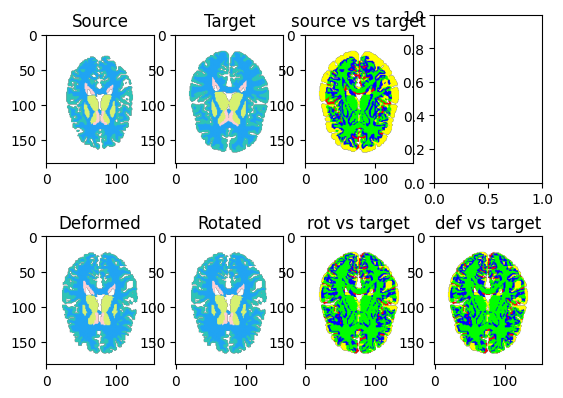

rigid_dice: {'(rotation only) dice val 1.0': tensor(0.6120), '(rotation only) dice val 2.0': tensor(0.5178), '(rotation only) dice val 3.0': tensor(0.8078), '(rotation only) dice val 4.0': tensor(0.6536), '(rotation only) dice val 5.0': tensor(0.8590), '(rotation only) dice average': tensor(0.6900)}
reg_dice: {'(all) dice val 1.0': tensor(0.6120), '(all) dice val 2.0': tensor(0.5178), '(all) dice val 3.0': tensor(0.8078), '(all) dice val 4.0': tensor(0.6536), '(all) dice val 5.0': tensor(0.8590), '(all) dice average': tensor(0.6900)}


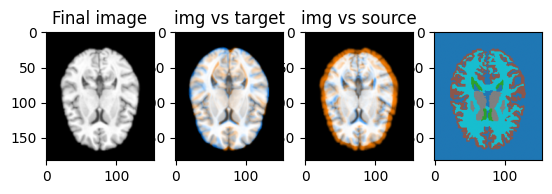

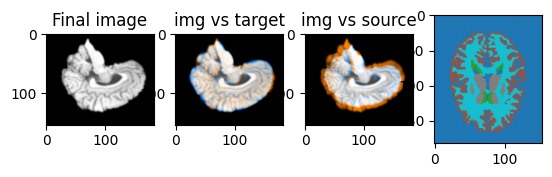

In [7]:
momenta = mtrt.prepare_momenta(
    # mr.source.shape,
    source_b.shape,
    image=False,
    rotation=True,
    translation=True,
    scaling=True,
    rot_prior=best_momentum_R.detach().clone(),trans_prior=best_momentum_T.detach().clone(),# - trans_s + trans_t,
    scale_prior=best_momentum_S.detach().clone(),
    device= "cpu"
)
print(momenta["momentum_R"])
print(momenta["momentum_T"])
kernelOperator = rk.GaussianRKHS(sigma=(10,10,10),normalized=False)
datacost = mt.Rotation_Ssd_Cost(target_b.to('cuda:0'), alpha=.5)
# datacost = mt.Rotation_Cost(target_b, mt.Mutual_Information, alpha=.5)
mr = mt.rigid_along_metamorphosis(
    source_b, target_b, momenta_ini=momenta,
    kernelOperator= kernelOperator,
    rho = 1,
    data_term=datacost ,
    integration_steps = 10,
    cost_cst=.1,
    n_iter=0,
    save_gpu_memory=False,
    lbfgs_max_iter = 20,
    lbfgs_history_size = 20,
)
mr.mp.forward(source_b.cpu(), momenta, save=True)

# mr.id_grid = mr.mp.id_grid
# mr.parameter = momenta
# mr.cost(momenta)
print('Estimated affines values:')
print("\t rotation matrix :", mr.mp.rot_mat)
print("\t translation :", mr.mp.translation)
print("\t scaling :", mr.mp.scale)

(rigid_dice, reg_dice), (rotated_source_segs, deformed_source_segs) = mr.compute_DICE(seg_source_b, seg_target_b)
print("rigid_dice:", rigid_dice)
print("reg_dice:", reg_dice)

# Hack un peu sale
# mr.to_analyse = (momenta, torch.zeros((4,1)))
# mr.save(f"{name}_ixibrain_rigidscalingonly",
        # save_path="/content/drive/MyDrive/demeter_data/demeter_optim/"
        # )


# a3s.Visualize_GeodesicOptim_plt(mr, "random")
rot_def = tb.grid_from_rotation_translation(mr.mp.id_grid, mr.mp.rot_mat, mr.mp.translation)
rot_def =   tb.grid_from_rotation(mr.mp.id_grid, mr.mp.rot_mat.T)
rot_def += mr.mp.translation
rot_def = mr.mp.get_rigidor()
rotated_source = tb.imgDeform(mr.mp.image,rot_def,dx_convention='2square')

img = rotated_source[0,0, mr.source.shape[-3]//2 -4].detach().cpu()
img_target = tb.imCmp(rotated_source[:,:, source.shape[-3]//2 -4].detach().cpu(), mr.target[:,:, source.shape[-3]//2 -4].detach().cpu(), "compose")[0]
img_source = tb.imCmp(rotated_source[:,:, source.shape[-3]//2 -4].detach().cpu(), mr.source[:,:, source.shape[-3]//2 -4].detach().cpu(), "compose")[0]

fig,ax = plt.subplots(1,4)
ax[0].imshow(img, cmap="gray")
ax[0].set_title("Final image")
ax[1].imshow(img_target, cmap="gray")
ax[1].set_title("img vs target")
ax[2].imshow(img_source, cmap="gray")
ax[2].set_title("img vs source")
ax[3].imshow(rotated_source_segs.detach()[0,0,  source.shape[-3]//2],
             cmap="tab10",
             # vmin=rotated_source.min(),
             # vmax=rotated_source.max()
             )

img = rotated_source[0,0, :,:,mr.source.shape[-1]//2 -4].detach().cpu()
img_target = tb.imCmp(rotated_source[:,:,  :,:,source.shape[-1]//2 -4].detach().cpu(), mr.target[:,:, :,:, source.shape[-1]//2 -4].detach().cpu(), "compose")[0]
img_source = tb.imCmp(rotated_source[:,:, :,:, source.shape[-1]//2 -4].detach().cpu(), mr.source[:,:, :,:, source.shape[-1]//2 -4].detach().cpu(), "compose")[0]

fig,ax = plt.subplots(1,4)
ax[0].imshow(img, cmap="gray")
ax[0].set_title("Final image")
ax[1].imshow(img_target, cmap="gray")
ax[1].set_title("img vs target")
ax[2].imshow(img_source, cmap="gray")
ax[2].set_title("img vs source")
ax[3].imshow(rotated_source_segs.detach()[0,0,  source.shape[-3]//2],
             cmap="tab10",
             # vmin=rotated_source.min(),
             # vmax=rotated_source.max()
             )

plt.show()

## LDDMM

ic| ipython-input-1872608661.py:7 in <cell line: 0>()
    momenta: {'momentum_I': tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
                        [0., 0., 0.,  ..., 0., 0., 0.],
                        [0., 0., 0.,  ..., 0., 0., 0.],
                        ...,
                        [0., 0., 0.,  ..., 0., 0., 0.],
                        [0., 0., 0.,  ..., 0., 0., 0.],
                        [0., 0., 0.,  ..., 0., 0., 0.]],
             
                       [[0., 0., 0.,  ..., 0., 0., 0.],
                        [0., 0., 0.,  ..., 0., 0., 0.],
                        [0., 0., 0.,  ..., 0., 0., 0.],
                        ...,
                        [0., 0., 0.,  ..., 0., 0., 0.],
                        [0., 0., 0.,  ..., 0., 0., 0.],
                        [0., 0., 0.,  ..., 0., 0., 0.]],
             
                       [[0., 0., 0.,  ..., 0., 0., 0.],
                        [0., 0., 0.,  ..., 0., 0., 0.],
                        [0., 0., 0.,  ..., 0., 0., 0.],
   

momenta type <class 'dict'>
	[DataCost  :(Rotation_Ssd_Cost) alpha = 0.3] :
	ssd = 21622.337890625, ssd_rot = 21622.5703125
	[DataCost  :(Rotation_Ssd_Cost) alpha = 0.3] :
	ssd = 21622.337890625, ssd_rot = 21622.5703125
	[DataCost  :(Rotation_Ssd_Cost) alpha = 0.3] :
	ssd = 356365.53125, ssd_rot = 21617.322265625
	[DataCost  :(Rotation_Ssd_Cost) alpha = 0.3] :
	ssd = 16828.515625, ssd_rot = 21621.861328125
	[DataCost  :(Rotation_Ssd_Cost) alpha = 0.3] :
	ssd = 12600.30078125, ssd_rot = 21622.201171875
	[DataCost  :(Rotation_Ssd_Cost) alpha = 0.3] :
	ssd = 12345.4951171875, ssd_rot = 21621.755859375
	[DataCost  :(Rotation_Ssd_Cost) alpha = 0.3] :
	ssd = 9770.630859375, ssd_rot = 21621.958984375
	[DataCost  :(Rotation_Ssd_Cost) alpha = 0.3] :
	ssd = 9500.802734375, ssd_rot = 21621.77734375
	[DataCost  :(Rotation_Ssd_Cost) alpha = 0.3] :
	ssd = 8770.779296875, ssd_rot = 21621.63671875
	[DataCost  :(Rotation_Ssd_Cost) alpha = 0.3] :
	ssd = 8227.486328125, ssd_rot = 21621.2265625
	[DataCost

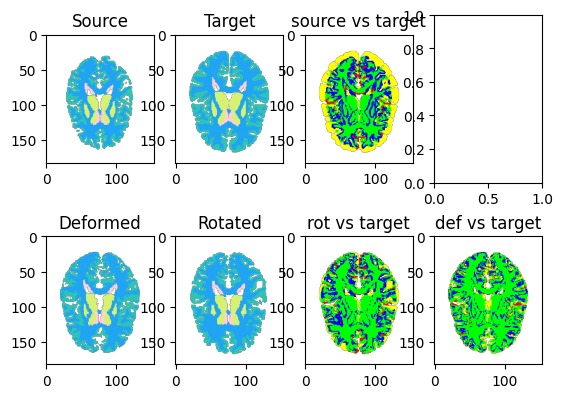

ic| abstract.py:1586 in save()
    path: '/content/drive/MyDrive/demeter_data/ixi_results/rigid_along_lddmm'



BUG WARNING : An other data term than Ssd was detectedFor now our method can't save it, it is ok to visualisethe optimisation, but be careful loading the optimisation.

Optimisation saved in /content/drive/MyDrive/demeter_data/ixi_results/rigid_along_lddmm/3D_20250925_IXI026-Guys-0696-T1_rigid_along_lddmm_root_001.pk1 

residual min 0.0 max 0.0


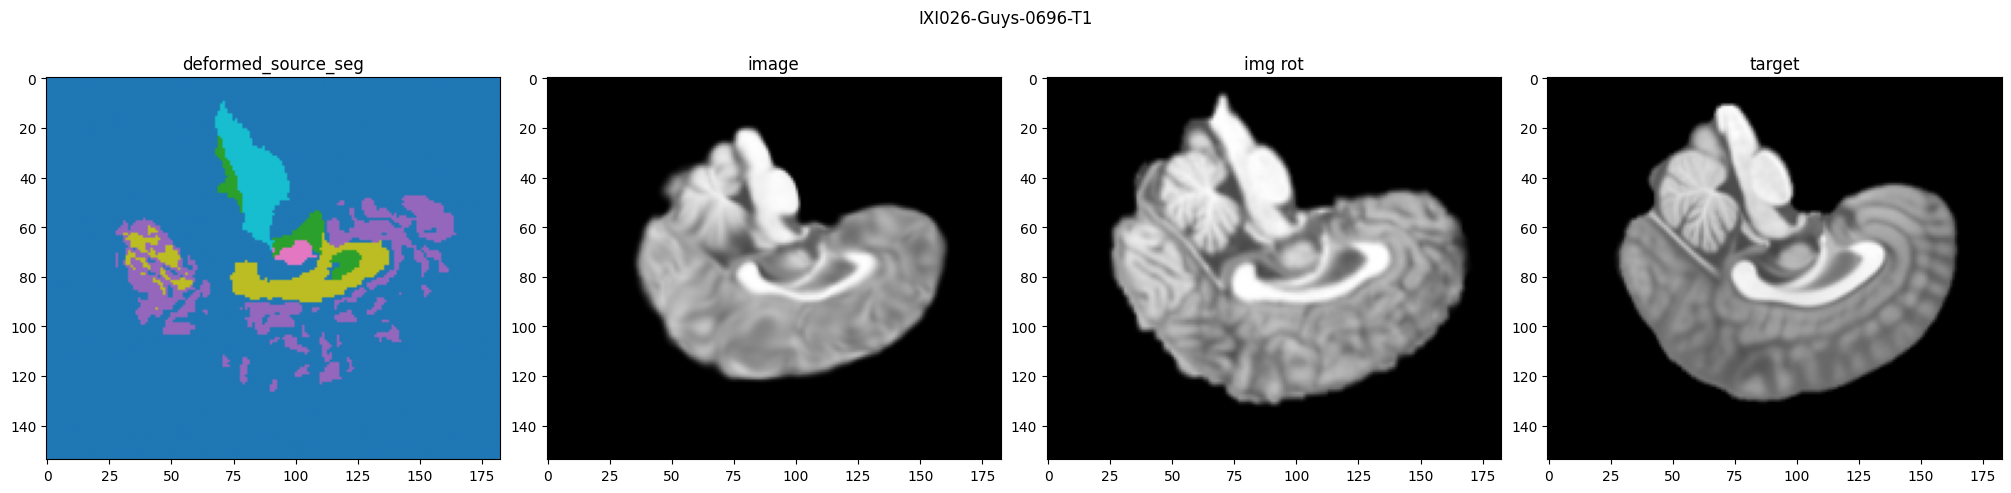

In [10]:

from datetime import datetime

sigma= [3, 5, 7]
sigma = [(s,)*3 for s in sigma]
kernelOperator = rk.Multi_scale_GaussianRKHS(sigma, normalized=False)

ic(momenta)

alpha = .3
rho = 1
cost_cst = .01
integration_steps = 10

datacost = mt.Rotation_Ssd_Cost(target_b.to("cuda:0"), alpha=alpha)
# datacost = mt.Rotation_MutualInformation_Cost(target_b, alpha=.5)
momenta = mt.prepare_momenta(
    source_b.shape,
    rot_prior=best_momentum_R.detach().clone(),trans_prior=best_momentum_T.detach().clone(),
    scale_prior=best_momentum_S.detach().clone(),
)

mr = mt.rigid_along_metamorphosis(
  source_b, target_b, momenta_ini=momenta,
  kernelOperator= kernelOperator,
  rho = rho,
  data_term=datacost ,
  integration_steps = integration_steps,
  cost_cst=cost_cst,
  cst_field = .9,
  n_iter=15,
  save_gpu_memory=False,
  lbfgs_max_iter = 20,
  lbfgs_history_size = 20,
  # hamiltonian_integration=True
)

dices, _ =mr.compute_DICE(seg_source_b, seg_target_b, verbose=True)
dice = dices[0] | dices[1]

file_save, path = mr.save(f"{subject_name}_rigid_along_lddmm",
                    light_save=True,
                    save_path = os.path.join(result_folder, "rigid_along_lddmm")
)
now = datetime.now()
# eit.log_metrics(
#     db_path,
#     patient_id=subject_name,
#     method="rigid_along_LDDMM",
#     metrics={'rigid_along_LDDMM ' + k: v for k,v in dice.items()},
#     run_id= str(now) + ' at ' + location,
#     step=0,
# meta={"gpu":torch.cuda.get_device_name(),
#                       "alpha" : alpha,
#                       "rho" : rho,
#                       "cost_cst" : cost_cst,
#                         "sigma" : sigma,
#                       "integration_steps" : integration_steps,
#                       "file": os.path.join(path, file_save)
#                       }
# )

# fig, ax = plt.subplots(1,3)
img_rot = tb.imgDeform(mr.source, mr.mp.get_rigidor())
T, _, D, H, W = source.shape
print(f"residual min {mr.mp.residuals.min()} max {mr.mp.residuals.max()}")
# Choose a central slice for plotting
slice_index = W // 2
fig, ax = plt.subplots(1,4,figsize = (20,5), constrained_layout=True)
ax[0].imshow(deformed_source_segs[0,0,..., slice_index].detach().cpu(), cmap='tab10')
ax[0].set_title(f'deformed_source_seg')
ax[1].imshow(mr.mp.image[0,0,..., slice_index].cpu(), cmap='gray')
ax[1].set_title(f'image')
ax[2].imshow(img_rot[0,0,..., slice_index], cmap='gray')
ax[2].set_title(f'img rot')

ax[3].imshow(mr.target[0,0,..., slice_index], cmap='gray')
ax[3].set_title(f'target')
fig.suptitle(subject_name)
plt.show()


In [9]:
tb.average_dice(mr.target_segmentation, mr.source_seg_deformed)

{' dice val 1.0': tensor(0.7333),
 ' dice val 2.0': tensor(0.5980),
 ' dice val 3.0': tensor(0.7968),
 ' dice val 4.0': tensor(0.7410),
 ' dice val 5.0': tensor(0.8811),
 ' dice average': tensor(0.7500)}

residual min 0.0 max 0.0


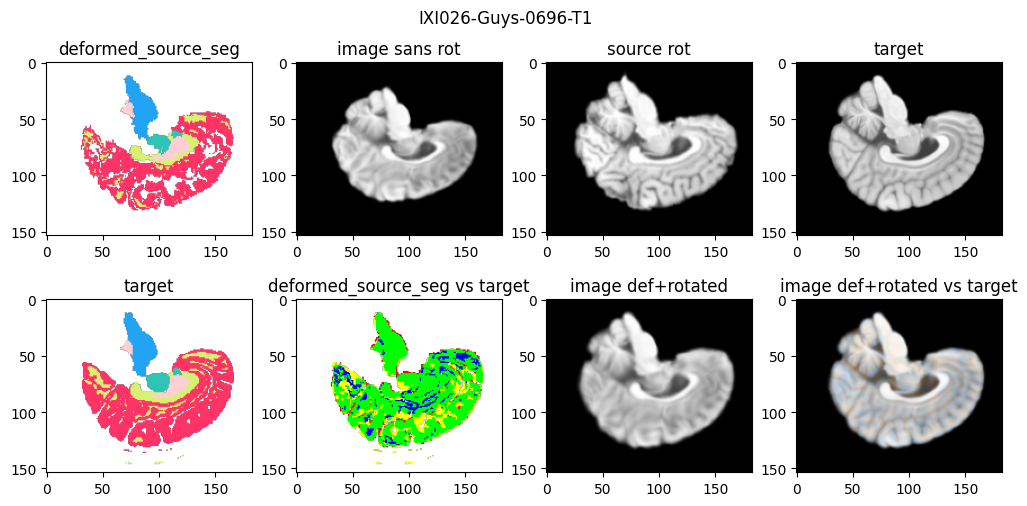

In [9]:

src_rot = tb.imgDeform(mr.source, mr.mp.get_rigidor())
img_rot = tb.imgDeform(mr.mp.image, mr.mp.get_rigidor())

cmp_img = tb.imCmp(img_rot, mr.target, "compose")[0]

cs = tb.SegmentationComparator()
cmp_seg = cs(mr.source_seg_deformed, mr.target_segmentation)[0]

T, _, D, H, W = source.shape
print(f"residual min {mr.mp.residuals.min()} max {mr.mp.residuals.max()}")
# Choose a central slice for plotting
slice_index = W // 2 +3
fig, ax = plt.subplots(2,4,figsize = (10,5), constrained_layout=True)
ax[0,0].imshow(mr.source_seg_deformed[0,0,..., slice_index].detach().cpu(), cmap =tb.DLT_SEG_CMAP, vmin=0, vmax = 5)
ax[0,0].set_title(f'deformed_source_seg')
ax[0,1].imshow(mr.mp.image[0,0,..., slice_index].cpu(), cmap='gray')
ax[0,1].set_title(f'image sans rot')
ax[0,2].imshow(src_rot[0,0,..., slice_index], cmap='gray')
ax[0,2].set_title(f'source rot')
ax[0,3].imshow(mr.target[0,0,..., slice_index], cmap='gray')
ax[0,3].set_title(f'target')

ax[1,0].imshow(mr.target_segmentation[0,0,..., slice_index], cmap =tb.DLT_SEG_CMAP, vmin=0, vmax = 5)
ax[1,0].set_title('target')

ax[1,1].imshow(cmp_seg[..., slice_index, :])
ax[1,1].set_title(f'deformed_source_seg vs target')



ax[1,2].imshow(img_rot[0,0,..., slice_index], cmap='gray')
ax[1,2].set_title('image def+rotated')

ax[1,3].imshow(cmp_img[..., slice_index,:], cmap='gray')
ax[1,3].set_title('image def+rotated vs target')



fig.suptitle(subject_name)
plt.show()


In [ ]:

mr.save(f"{name}_ixibrain_rigidscalingLDDMM_colab",
        # save_path="/content/drive/MyDrive/demeter_data/demeter_optim/"
        )
